# SNR and resolution measurements on gold NPs
---
#### Overview
* Load and preview images
* Demonstrate SSNR measurement on an individual image
* Plot resolution as found with FEI image

In [1]:
from pathlib import Path
import re
from itertools import product, combinations

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from skimage import img_as_float, img_as_uint
from skimage.util import crop
import tifffile

In [2]:
# Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)

# import functions
import ssnr

# 1. SSNR measurement on gold nanoparticle
---
### Individual SSNR measurement

C:\Users\ajkievits\Git\sb_optical_STEM\Notebooks\../code\ssnr.py:70: RuntimeWarning: invalid value encountered in true_divide
  SSNR = (K-1) * num / (K * den) - 1


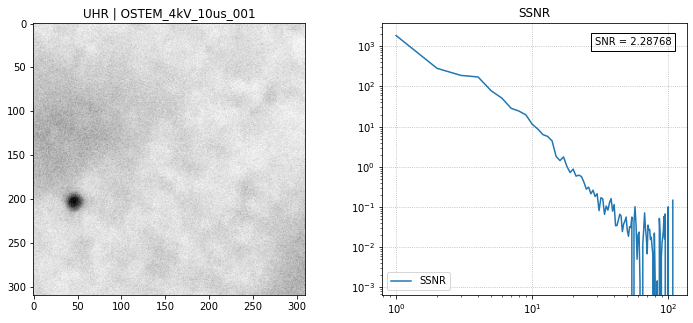

In [3]:
im = Path('../data/Resolution/Old/OSTEM_4000V_0V-SB/UHR/crops/OSTEM_4kV_10us_001.tif')
image = img_as_float(tifffile.imread(im.as_posix()))
# Compute SSNR, and SNR
crop_width = (((image.shape[0] - 310) // 2,) * 2,
              ((image.shape[1] - 310) // 2,) * 2)
cropped = crop(image, crop_width=crop_width, copy=True)
images = ssnr.split_image(cropped)
snr = ssnr.SSNR_full(images)
ssnr_rings = ssnr.SSNR_ring(images)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].imshow(cropped, cmap='Greys_r')
axes[1].plot(ssnr_rings, label='SSNR')
axes[1].text(0.95, 0.95, f'SNR = {snr:.5f}', ha='right', va='top',
             transform=axes[1].transAxes, bbox={'facecolor':'none'})
# Aesthetics
axes[0].set_title(f'{im.parents[1].name} | {im.stem}')
axes[1].set_title('SSNR')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(loc=3)
axes[1].grid(ls=':')

# 2. Resolution measurement of detection modes using relative size of particle populations
---
## 2.1 Load image data

In [53]:
# Find directory
DATA_dir = Path("../data/4_Resolution-detectors/New-analysis/UHR")

# Select files and initialize DataFrame with image locations
df_im = pd.DataFrame({'FilePos': list(DATA_dir.glob('*.tif'))})

# Build up DataFrame
#df_im['DETECTION_MODE'] = df_im['FilePos'].apply(lambda x: x.parent.name)
#df_im['kV'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[0].split('kV')[0])
df_im['DetectionMode'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[0])
df_im['Dwell'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])
df_im['LE'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[1].split('keV')[0])

# Preview
df_im.sort_values(['DetectionMode', 'LE'], inplace=True)
df_im.sample(5)

,FilePos,DetectionMode,Dwell,LE
11,..\data\4_Resolution-detectors\New-analysis\UH...,OSTEM,10000,4
27,..\data\4_Resolution-detectors\New-analysis\UH...,SE,10000,4
26,..\data\4_Resolution-detectors\New-analysis\UH...,SE,10000,4
3,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,20000,1.5
13,..\data\4_Resolution-detectors\New-analysis\UH...,OSTEM,10000,4


## 2.2 Blob detection for single gold particle image

In [7]:
# Imports
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

In [8]:
df_im['FilePos'].loc[4]

WindowsPath('../data/4_Resolution-detectors/New-analysis/UHR/BSE_4keV_10000ns_002.tif')

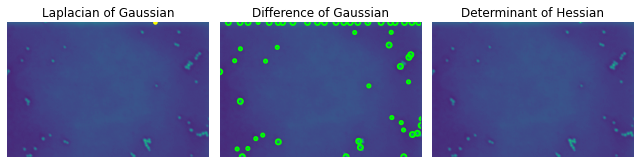

In [236]:
# Read first image
im = img_as_uint(tifffile.imread(df_im['FilePos'].loc[0].as_posix()))
image_gray = im[:2048,::].astype('uint8')

# Actual bloc detection using Laplacian of Gaussian (LoG), Difference of Gaussian (DoG) and Determinant of Hessian (DoH)
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image_gray)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

In [30]:
import itertools

### 2.2.1 Optimize blob detection

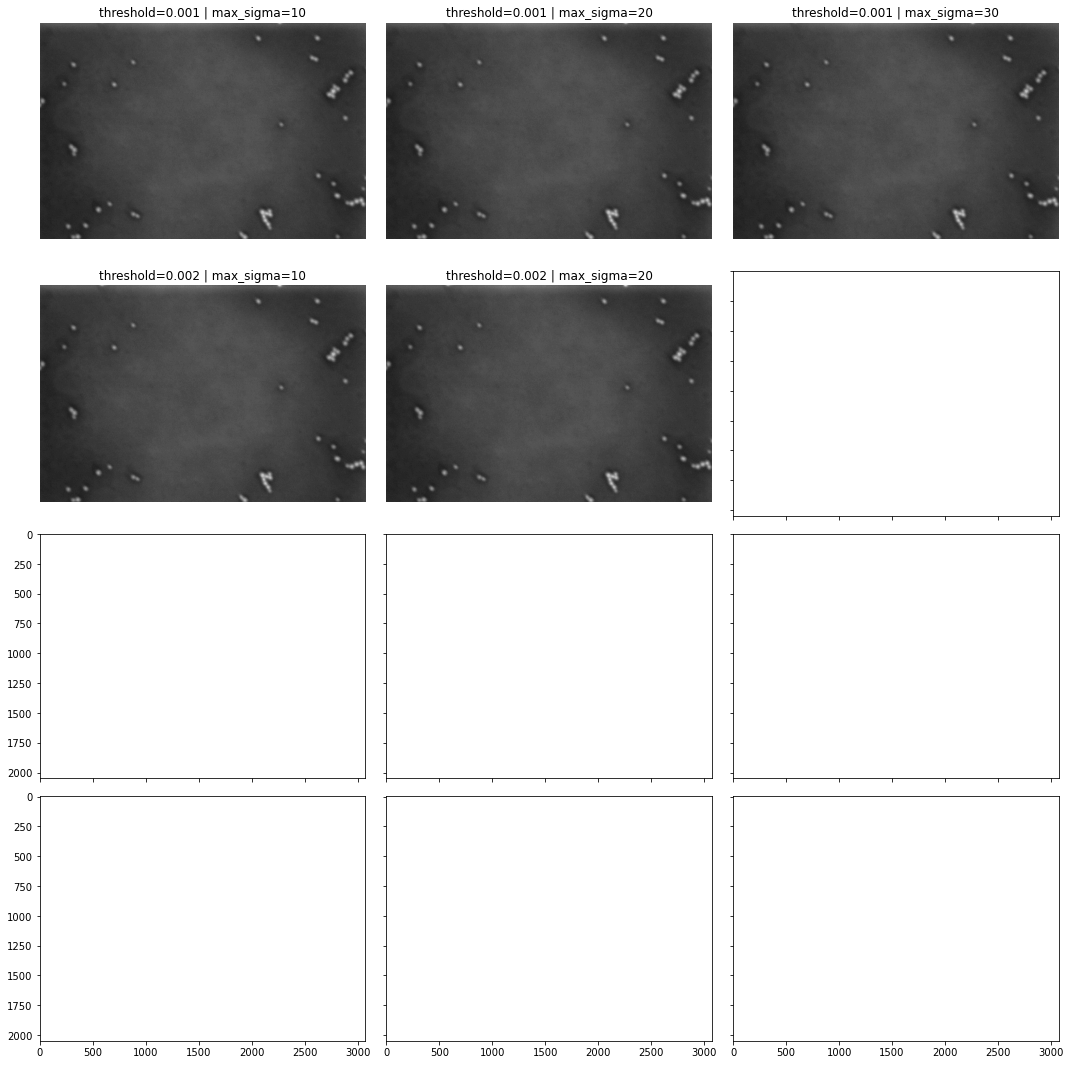

In [235]:
# Read first image
im = img_as_uint(tifffile.imread(df_im['FilePos'].loc[0].as_posix()))
image_gray = im[:2048,::].astype('uint8')

# Define parameter range
threshold_range = [.001,.002,.005,.01]
max_sigma_range = [10, 20, 30]
param_range = list(itertools.product(*[threshold_range, max_sigma_range]))

# Initialize figure
title = 'Determinant of Hessian'
nrows = len(threshold_range) # include row for image
ncols = len(max_sigma_range)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.75*nrows), 
                       sharex=True, sharey=True)

# # Blob detection using determinant of hessian (DoH)
# blobs_list = []
# for thres, sigma in tqdm(seq, total=ncols):
#     blobs_doh = blob_doh(image_gray, max_sigma=sigma, threshold=thres)
#     blobs_list.append(blobs_doh)

# Iterate through parameters and list of detections
for params, blobs, ax in zip(param_range, blobs_list, axes.ravel()):
    ax.set_title(f"threshold={params[0]} | max_sigma={params[1]}")
    ax.imshow(image_gray, cmap='Greys_r')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### 2.2.2 Blob detection for series of images

In [223]:
# One image per detection condition
source = df_im.groupby(by=['DetectionMode', 'LE','Dwell'])\
              .apply(lambda x: x.head(1))\
              .droplevel(['DetectionMode','LE','Dwell'])\
              .reset_index()\
              .copy()
source

,index,FilePos,DetectionMode,Dwell,LE
0,0,..\data\Resolution\New-analysis\UHR\BSE_1.5keV...,BSE,20000,1.5
1,4,..\data\Resolution\New-analysis\UHR\BSE_4keV_1...,BSE,10000,4
2,9,..\data\Resolution\New-analysis\UHR\OSTEM_4keV...,OSTEM,10000,4
3,14,..\data\Resolution\New-analysis\UHR\SE_1.5keV_...,SE,10000,1.5
4,21,..\data\Resolution\New-analysis\UHR\SE_4keV_10...,SE,10000,4


In [232]:
# Blob detection
threshold = .01
max_sigma = 30

# Blob detection using determinant of hessian (DoH)
blobs_list = []
for i, row in tqdm(source.iterrows(), total=len(source)):
    
    # Load image
    image = tifffile.imread(row['FilePos'].as_posix())
    cropped = im[:2048,::].astype('uint8')
    
    # DoH
    blobs_doh = blob_doh(cropped, max_sigma=max_sigma, threshold=threshold)
    blobs_list.append(blobs_doh)

  0%|          | 0/5 [00:00<?, ?it/s]

IndexError: index 2 is out of bounds for axis 0 with size 0

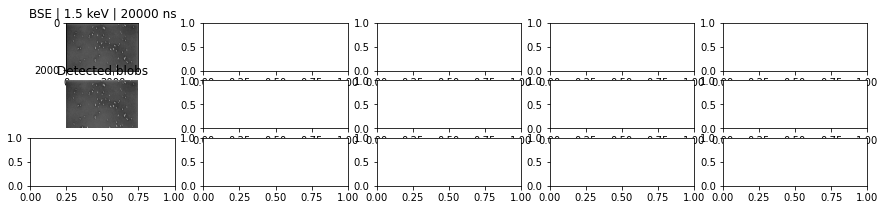

In [227]:
# Make figure
fig, axes = plt.subplots(ncols=len(source), nrows=3,
                         figsize=(5*len(source), 5))
axmap = {k: v for k, v in zip(source.index, axes.T)}

for (i, row), blobs in zip(source.iterrows(), blobs_list):
    ax = axmap[i]
    
    # Plot image
    image = tifffile.imread(row['FilePos'].as_posix())
    cropped = im[:2048,::].astype('uint8')
    ax[0].imshow(cropped, cmap='Greys_r')
    ax[0].set_title(f"{row['DetectionMode']} | {row['LE']} keV | {row['Dwell']} ns")
    
    # Plot image + blobs
    ax[1].set_title('Detected blobs')
    ax[1].imshow(image_gray, cmap='Greys_r')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax[1].add_patch(c)
    ax[1].set_axis_off()
    
    # Plot histogram of blob size
    counts, bins = np.histogram([blob[2] for blob in blobs_list])
    ax[2].hist(bins[:-1], bins, weights=counts)

plt.tight_layout()
plt.show()

## 2.3 Detection using thresholding

In [54]:
from skimage.filters import try_all_threshold
from skimage.filters import gaussian 

In [58]:
df_im

,FilePos,DetectionMode,Dwell,LE
0,..\data\4_Resolution-detectors\New-analysis\UH...,ADF-STEM,3000,28
1,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,20000,1.5
2,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,20000,1.5
3,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,20000,1.5
4,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,10000,4
5,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,10000,4
6,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,10000,4
7,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,10000,4
8,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,10000,4
9,..\data\4_Resolution-detectors\New-analysis\UH...,OSTEM,10000,4


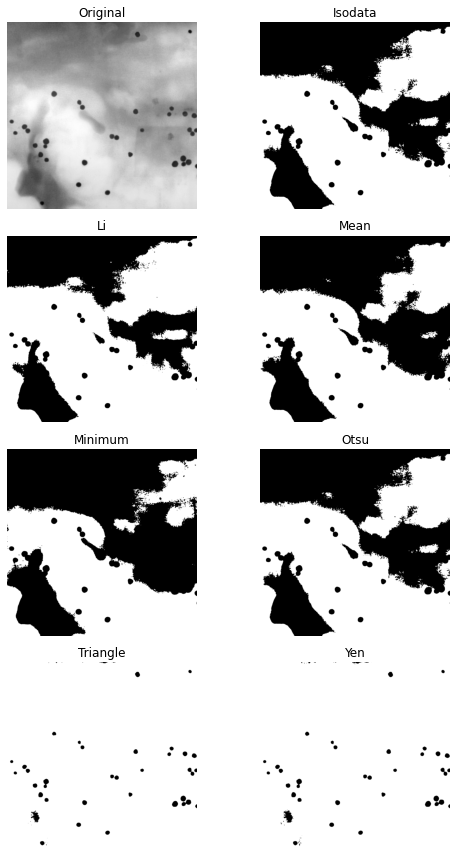

In [68]:
# Read first image
im = img_as_uint(tifffile.imread(df_im['FilePos'].loc[0].as_posix()))
image_gray = im[:2048,::].astype('uint16')
smoothed = gaussian(image_gray, sigma=1)

fig, ax = try_all_threshold(smoothed, figsize=(8, 12), verbose=False)
plt.show()

### 2.3.1 Detection using  thresholding for one image

In [55]:
from skimage.filters import threshold_otsu, threshold_triangle, threshold_yen
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from scipy import ndimage as ndi
import matplotlib.patches as mpatches

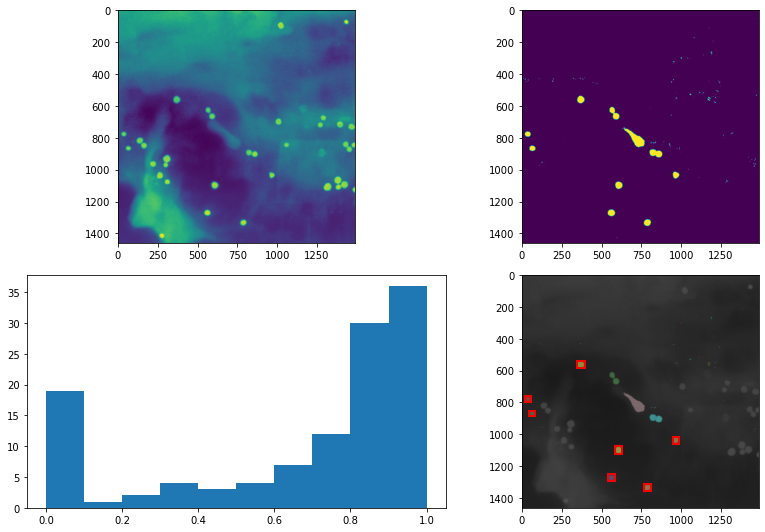

In [72]:
# Read first image
im = img_as_uint(tifffile.imread(df_im['FilePos'].loc[0].as_posix()))
image = im[:2048,::]
image = gaussian(image, sigma=1)

# Apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(5))

# remove objects connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

# Calculate features from labels
props = regionprops(label_image, image)
ecc = [prop.eccentricity for prop in props]
counts, bins = np.histogram(ecc)

fig, ax = plt.subplots(2, 2, figsize=(12, 7.5))
ax[0][0].imshow(image)
ax[0][1].imshow(cleared)
ax[1][0].hist(bins[:-1], bins, weights=counts)
ax[1][1].imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if (region.area > 100) & (region.eccentricity <= 0.6):
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax[1][1].add_patch(rect)

plt.tight_layout()
plt.show()

### 2.3.2 Apply thresholding to series of images

In [56]:
# One image per detection condition
source = df_im.groupby(by=['DetectionMode', 'LE','Dwell'])\
              .apply(lambda x: x.sample(1))\
              .droplevel(['DetectionMode','LE','Dwell'])\
              .reset_index()\
              .copy()
source

,index,FilePos,DetectionMode,Dwell,LE
0,0,..\data\4_Resolution-detectors\New-analysis\UH...,ADF-STEM,3000,28
1,3,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,20000,1.5
2,5,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,10000,4
3,10,..\data\4_Resolution-detectors\New-analysis\UH...,OSTEM,10000,4
4,19,..\data\4_Resolution-detectors\New-analysis\UH...,SE,10000,1.5
5,21,..\data\4_Resolution-detectors\New-analysis\UH...,SE,10000,4


  0%|          | 0/6 [00:00<?, ?it/s]

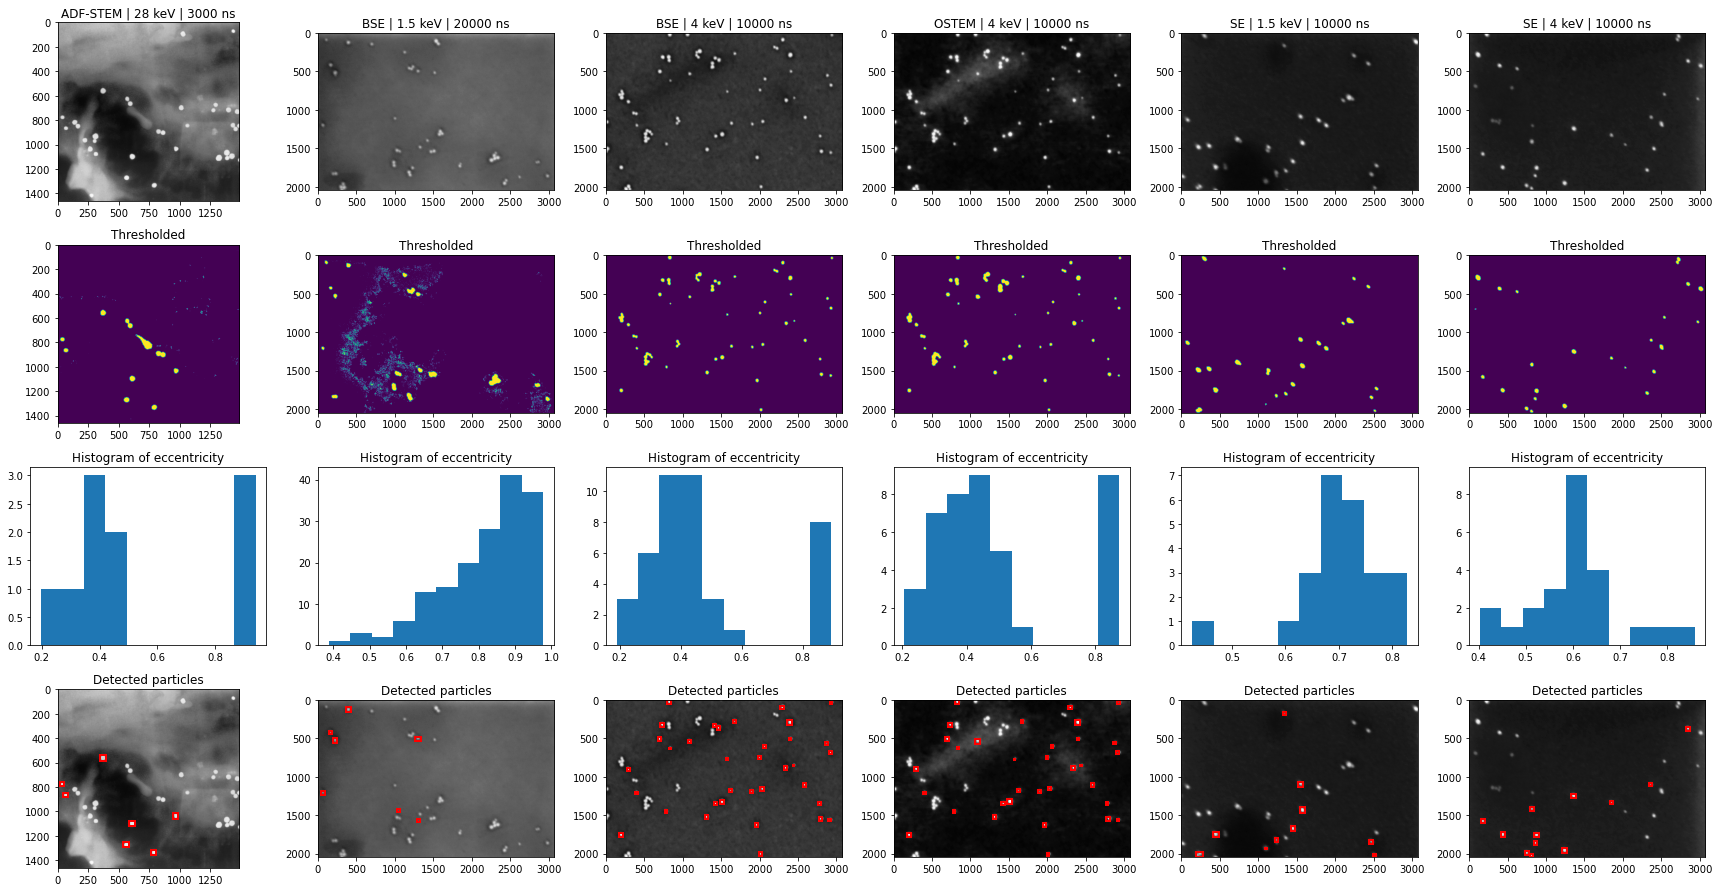

In [74]:
# Make figure
fig, axes = plt.subplots(ncols=len(source), nrows=4,
                         figsize=(4*len(source), 2.5*5))
axmap = {k: v for k, v in zip(source.index, axes.T)}

for i, row in tqdm(source.iterrows(), total=len(source)):
    ax = axmap[i]
    
    # Read and smooth image
    im = img_as_uint(tifffile.imread(row['FilePos'].as_posix()))
    cropped = im[:2048,::]
    image = gaussian(cropped, sigma=1)
    
    # Apply Otsu threshold
    thresh = threshold_otsu(image)
    bw = closing(image > thresh, square(5))
    cleared = clear_border(bw) # remove objects connected to image border
    
    # label image regions
    label_image = label(cleared)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    # Calculate features from labels for histogram
    props = regionprops(label_image, image)
    ecc = [prop.eccentricity for prop in props if prop.area > 100]
    counts, bins = np.histogram(ecc)
    
    # Plot images
    ax[0].imshow(cropped, cmap='Greys_r')
    ax[0].set_title(f"{row['DetectionMode']} | {row['LE']} keV | {row['Dwell']} ns")
    ax[1].imshow(cleared)
    ax[1].set_title('Thresholded')
    ax[2].hist(bins[:-1], bins, weights=counts)
    ax[2].set_title('Histogram of eccentricity')
     
    # Plot image + detected particles
    ax[3].set_title('Detected particles')
    ax[3].imshow(cropped, cmap='Greys_r')
    
    if (row['DetectionMode'] == 'SE') & (row['LE'] == '1.5'): 
        ecc_thres = 0.7
    else: 
        ecc_thres = 0.6
    for region in regionprops(label_image):
        # take regions with large enough areas
        if (region.area > 200) & (region.eccentricity <= ecc_thres):
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax[3].add_patch(rect)

plt.tight_layout()
plt.savefig('otsu_thresholding', dpi=150)
plt.show()

### 2.3.3 Automated analysis of all images

In [75]:
source1 = df_im.groupby(by=['DetectionMode', 'LE','Dwell'])\
              .apply(lambda x: x.head(1))
source1

FilePos  \
DetectionMode LE  Dwell                                                         
ADF-STEM      28  3000  0   ..\data\4_Resolution-detectors\New-analysis\UH...   
BSE           1.5 20000 1   ..\data\4_Resolution-detectors\New-analysis\UH...   
              4   10000 4   ..\data\4_Resolution-detectors\New-analysis\UH...   
OSTEM         4   10000 9   ..\data\4_Resolution-detectors\New-analysis\UH...   
SE            1.5 10000 14  ..\data\4_Resolution-detectors\New-analysis\UH...   
              4   10000 21  ..\data\4_Resolution-detectors\New-analysis\UH...   

                           DetectionMode  Dwell   LE  
DetectionMode LE  Dwell                               
ADF-STEM      28  3000  0       ADF-STEM   3000   28  
BSE           1.5 20000 1            BSE  20000  1.5  
              4   10000 4            BSE  10000    4  
OSTEM         4   10000 9          OSTEM  10000    4  
SE            1.5 10000 14            SE  10000  1.5  
              4   10000 21            SE  10000    4

In [76]:
# Detect particles for every image
# Data
source = df_im.copy()

# Initialize DataFrame for particle measurements
df_particles = pd.DataFrame(columns=['FilePos', 'DetectionMode', 'LE', 
                                     'Dwell', 'ParticleSize'])

for grp in tqdm(df_im.groupby(by=['DetectionMode', 'LE','Dwell'])):
    
    # Select subset of images with same detection settings
    for i, row in tqdm(grp[1].iterrows(), total=len(grp[1])):
    
        # Read and smooth image
        im = img_as_uint(tifffile.imread(row['FilePos'].as_posix()))
        cropped = im[:2048,::]
        image = gaussian(cropped, sigma=1)
        
        # Threshold image
        thresh = threshold_otsu(image)
        bw = closing(image > thresh, square(5))
        cleared = clear_border(bw) # remove objects connected to image border

        # label image regions
        label_image = label(cleared)
        # to make the background transparent, pass the value of `bg_label`,
        # and leave `bg_color` as `None` and `kind` as `overlay`
        image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
        
        # Exception for SE @ 1.5 keV because of stigmation
        if (row['DetectionMode'] == 'SE') & (row['LE'] == '1.5'): 
            ecc_thres = 0.8
        else: 
            ecc_thres = 0.6
            
        # Calculate features from labels for histogram
        props = regionprops(label_image, image)
        particle_size = [0.5*prop.minor_axis_length for prop in props if (prop.eccentricity <= ecc_thres) & (prop.area > 200)]

        # Populate DataFrame
        df_particles.loc[i, 'FilePos'] = row['FilePos']
        df_particles.loc[i, 'DetectionMode'] = row['DetectionMode']
        df_particles.loc[i, 'LE'] = row['LE']
        df_particles.loc[i, 'Dwell'] = row['Dwell']
        df_particles.loc[i, 'ParticleSize'] = particle_size 
df_particles.sample(3)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

,FilePos,DetectionMode,LE,Dwell,ParticleSize
9,..\data\4_Resolution-detectors\New-analysis\UH...,OSTEM,4,10000,"[25.63787732539548, 22.048395104912117, 17.738..."
2,..\data\4_Resolution-detectors\New-analysis\UH...,BSE,1.5,20000,"[27.477657804061867, 47.418056984331145, 41.96..."
11,..\data\4_Resolution-detectors\New-analysis\UH...,OSTEM,4,10000,"[20.10506379409901, 15.87915699495649, 17.7271..."


In [77]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from matplotlib import cycler
import matplotlib as mpl

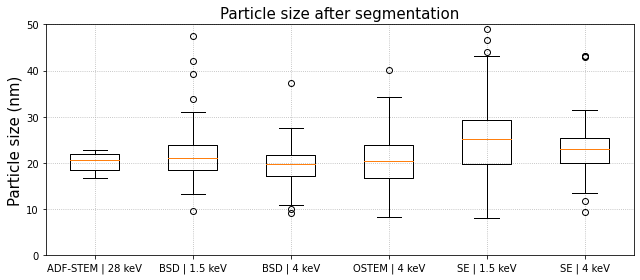

In [82]:
# Data
source = df_particles.copy()
fs = 15

# Make figure
fig, ax = plt.subplots(figsize=(9, 4))
sizes = []
labels = []
legend = ['ADF-STEM','BSD','BSD','OSTEM','SE','SE']

# Plot results
for j, grp in enumerate(source.groupby(by=['DetectionMode', 'LE', 'Dwell'])):
    
    # Aggregate particles per subset of images
    particle_subset = []
    
    # Select subset of images with same detection settings
    for i, row in grp[1].iterrows():
        particle_sizes = row['ParticleSize']
        particle_subset = particle_subset + particle_sizes
    sizes.append(particle_subset)
    labels.append(f"{legend[j]} | {row['LE']} keV")

# Plot boxplot
ax.boxplot(sizes, labels=labels)   

# Axes aesthetics
ax.grid(which='both', ls=':') 
ax.set_title('Particle size after segmentation', fontsize=fs)
ax.set_ylabel('Particle size (nm)', fontsize=fs)
ax.set_ylim(0, 50)
plt.tight_layout()    
plt.savefig('Otsu-resolution', dpi=150)

### 2.6 Watershed Segmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

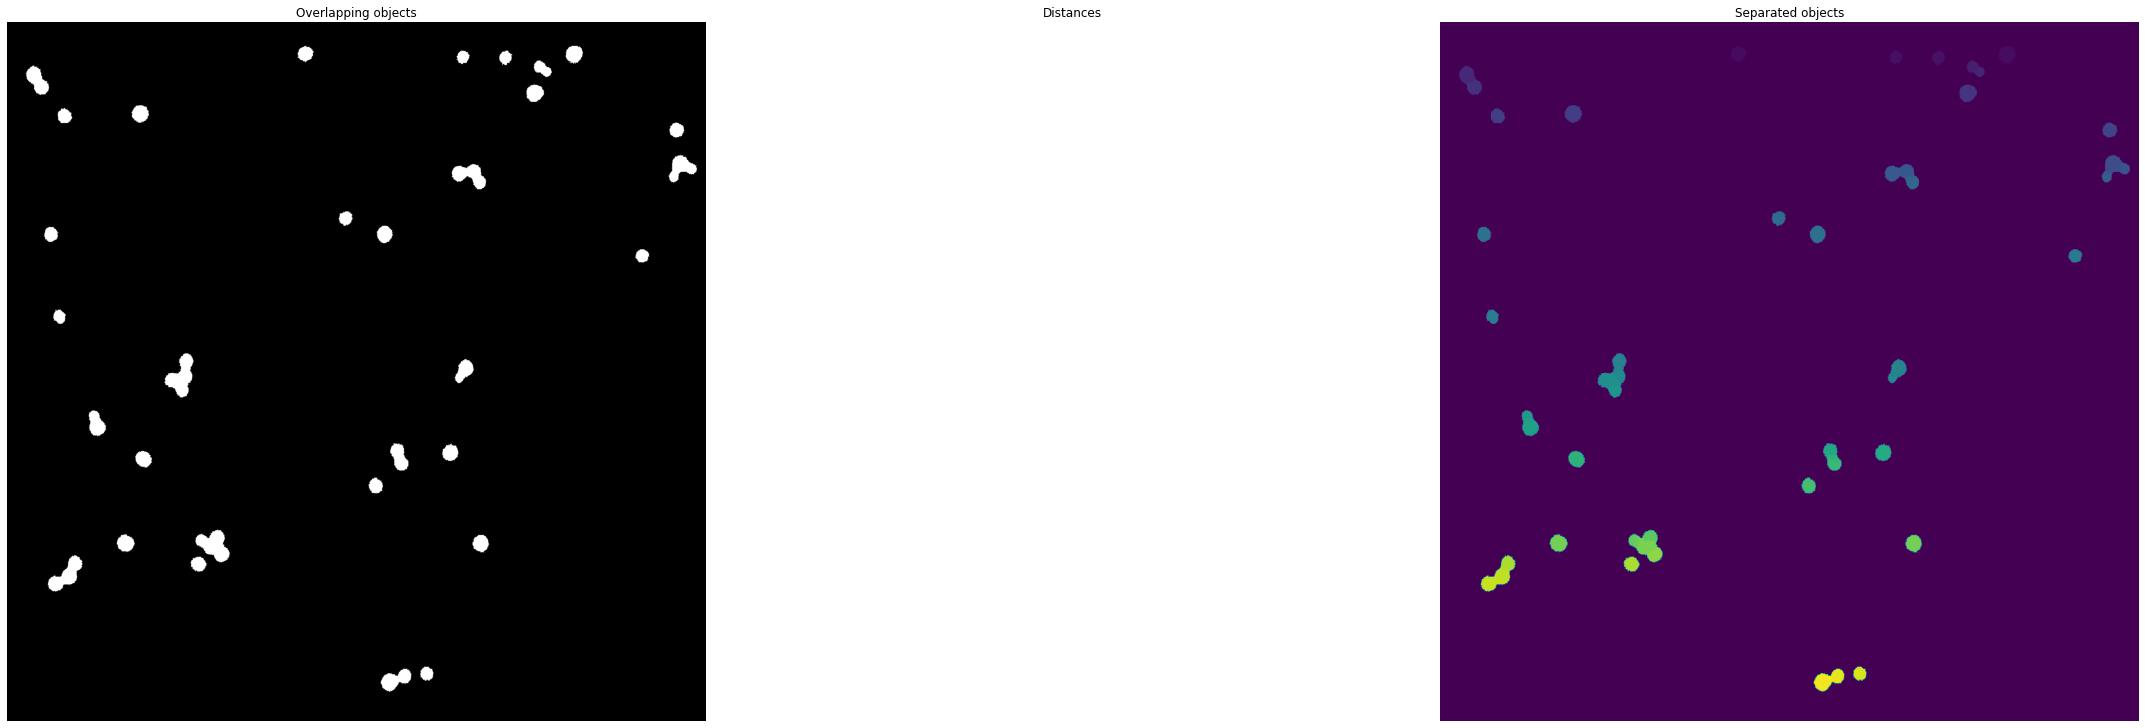

In [86]:
# Read first image
im = img_as_uint(tifffile.imread(df_im['FilePos'].loc[4].as_posix()))
image = im[:2048,:2048].astype('uint8')

# Apply Otsu threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove objects connected to image border
cleared = clear_border(bw)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(cleared)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=cleared)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=cleared)

fig, axes = plt.subplots(ncols=3, figsize=(30, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(cleared, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

## 3. Resolution measurement of detection modes using FEI Image
---
### 3.1 Load edge width data measured with FEI Image

In [78]:
data = Path('../data/4_Resolution-detectors/New/Resolution/Res_data_new_filter.csv')
data = pd.read_csv(data, delimiter=';')
data['Detection Condition'] = data['Detection Mode'] + ' | ' + data['LE']
data.sample(6)

,MODE,Detection Mode,Pixel size (nm),Dwell,LE,25%-75% width (nm),35%-65% width (nm),Detection Condition
9,UHR,OSTEM,0.5,10000 ns,4 keV,5.481,3.119,OSTEM | 4 keV
12,UHR,OSTEM,0.5,10000 ns,4 keV,5.647,3.213,OSTEM | 4 keV
32,UHR,SE,0.5,10000 ns,4 keV,6.486,3.683,SE | 4 keV
2,UHR,BSE,0.5,20000 ns,1.5 keV,6.555,3.899,BSE | 1.5 keV
16,UHR,SE,0.5,20000 ns,1.5 keV,8.111,4.637,SE | 1.5 keV
8,UHR,BSE,0.5,10000 ns,4 keV,5.547,3.181,BSE | 4 keV


### 3.2 Plot

In [11]:
# Data source for plot
source = data.copy()
# source = df_snr.copy()
scheme = 'category10'

chart = alt.Chart().encode(
    x=alt.X('Modality:N', axis=alt.Axis(labels=False)),
    y=alt.Y('35%-65% width (nm)',
            aggregate='mean',
            scale=alt.Scale(domain=[0, 6])),
    color=alt.Color('Modality:N',
                    scale=alt.Scale(scheme=scheme),
                    )
).properties(width=400,
             height=225)

chart = (chart.mark_line() +\
         chart.mark_point(size=80))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('Modality:N'),
    y=alt.Y('35%-65% width (nm)'),
    color=alt.Color('Modality:N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).configure_axis(
    labelFontSize=20,
    titleFontSize=20
    
).configure_legend(labelLimit=0, 
                   titleFontSize=25,
                   labelFontSize=25,
                   )


alt.LayerChart(...)

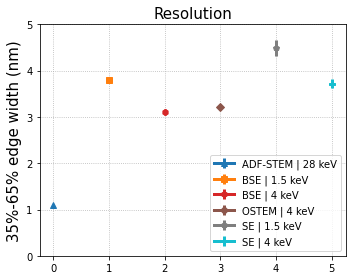

In [51]:
# Data
source = data.copy()
fs = 15

# Colormap
cmap = plt.get_cmap('tab10')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1.1, len(source['Detection Condition'].unique()))))

# Make figure
fig, ax = plt.subplots(figsize=(5, 4))
edgewidths = []
labels = []
markers=["^","s","h","D","p","P"]

# Plot results
for j, grp in enumerate(source.groupby(by=['Detection Condition'])):
    
    # Calculate mean and std of SSNR
    mean = grp[1]['35%-65% width (nm)'].mean()
    std = grp[1]['35%-65% width (nm)'].std()
    
    # Plot 
    ax.errorbar(j, mean, yerr=std, linewidth=3, marker=markers[j], markersize=6)
    labels.append(grp[1]['Detection Condition'].iloc[0])
    
# Axes aesthetics
ax.grid(which='both', ls=':') 
ax.set_title('Resolution', fontsize=fs)
#ax.set_xticks(range(j+1), labels=labels)
ax.legend(labels, fontsize=fs-5)
ax.set_ylabel('35%-65% edge width (nm)', fontsize=fs)
ax.set_ylim(0, 5)
plt.tight_layout()    
plt.savefig('Edge-resolution', dpi=150)

## 3. Resolution measurement of detection modes using FEI Image | Distribution of edge widths
---
### 3.1 Load edge width data measured with FEI Image

In [90]:
# Find directory
DATA_dir = Path("../data/4_Resolution-detectors/Final/UHR")

# Select files and initialize DataFrame with image locations
df_ew = pd.DataFrame({'FilePos': list(DATA_dir.glob('*/*.csv'))})

# Build up DataFrame
#df_im['DETECTION_MODE'] = df_im['FilePos'].apply(lambda x: x.parent.name)
#df_im['kV'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[0].split('kV')[0])
df_ew['DetectionMode'] = df_ew['FilePos'].apply(lambda x: x.parent.name.split('_')[0])
df_ew['Dwell'] = df_ew['FilePos'].apply(lambda x: x.parent.name.split('_')[3].split('ns')[0])
df_ew['Pxsize'] = df_ew['FilePos'].apply(lambda x: x.parent.name.split('_')[2].split('nm')[0])
df_ew['LE'] = df_ew['FilePos'].apply(lambda x: x.parent.name.split('_')[1].split('keV')[0])

# Preview
df_ew.sort_values(['DetectionMode', 'LE'], inplace=True)
df_ew.sample(5)

,FilePos,DetectionMode,Dwell,Pxsize,LE
28,..\data\4_Resolution-detectors\Final\UHR\SE_4k...,SE,10000,0.5,4
4,..\data\4_Resolution-detectors\Final\UHR\ADF-S...,ADF-STEM,3000,0.2,25
8,..\data\4_Resolution-detectors\Final\UHR\BSD_1...,BSD,20000,0.5,1.5
10,..\data\4_Resolution-detectors\Final\UHR\BSD_4...,BSD,10000,0.5,4
26,..\data\4_Resolution-detectors\Final\UHR\SE_4k...,SE,10000,0.5,4


In [91]:
source2 = df_ew.groupby(by=['DetectionMode', 'LE','Dwell'])\
              .apply(lambda x: x.head(1))
source2

FilePos  \
DetectionMode LE  Dwell                                                         
ADF-STEM      25  3000  0   ..\data\4_Resolution-detectors\Final\UHR\ADF-S...   
BSD           1.5 20000 6   ..\data\4_Resolution-detectors\Final\UHR\BSD_1...   
              4   10000 9   ..\data\4_Resolution-detectors\Final\UHR\BSD_4...   
OSTEM         4   10000 14  ..\data\4_Resolution-detectors\Final\UHR\OSTEM...   
SE            1.5 10000 19  ..\data\4_Resolution-detectors\Final\UHR\SE_1....   
              4   10000 26  ..\data\4_Resolution-detectors\Final\UHR\SE_4k...   

                           DetectionMode  Dwell Pxsize   LE  
DetectionMode LE  Dwell                                      
ADF-STEM      25  3000  0       ADF-STEM   3000    0.2   25  
BSD           1.5 20000 6            BSD  20000    0.5  1.5  
              4   10000 9            BSD  10000    0.5    4  
OSTEM         4   10000 14         OSTEM  10000    0.5    4  
SE            1.5 10000 19            SE  10000    0.5  1.5  
              4   10000 26            SE  10000    0.5    4

In [92]:
# Get histograms of edge widths
source2 = df_ew.copy()

# Initialize DataFrame to gather data per detection condition
df_ew_per_con = pd.DataFrame(columns=['DetectionMode', 'LE', 
                                     'Dwell', 'EdgeWidths'])

# Select subset of data files with same detection settings
for grp in tqdm(source2.groupby(by=['DetectionMode', 'LE','Dwell'])):
    
    # Select subset of data files with same detection settings
    for i, row in tqdm(grp[1].iterrows(), total=len(grp[1])):
        
        # Create empty array for edge widths
        ews = np.array([])
        
        # Read csv
        dist = np.loadtxt(row.FilePos, delimiter='  ')
        
        # Fill up np array with data
        data = np.zeros(int(np.sum(dist[:,1])))
        start = 0
        for value in dist:
            norv = int(value[1]) # number of repeated values
            data[start:(start+norv)] = value[0]
            start = start + norv # update
        data = data * 1e9
            
        # Populate DataFrame
        df_ew_per_con.loc[i, 'DetectionMode'] = row['DetectionMode']
        df_ew_per_con.loc[i, 'LE'] = row['LE']
        df_ew_per_con.loc[i, 'Dwell'] = row['Dwell']
        df_ew_per_con.loc[i, 'EdgeWidths'] = data.tolist()
df_ew_per_con.sample(3)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

,DetectionMode,LE,Dwell,EdgeWidths
31,SE,4,10000,"[1.66360281106392, 1.66360281106392, 1.6636028..."
10,BSD,4,10000,"[1.4879645293675001, 1.4879645293675001, 1.487..."
29,SE,4,10000,"[1.55785173650003, 1.55785173650003, 1.6015969..."


---
### 3.2 Plot distributions of edge with per detection methdo

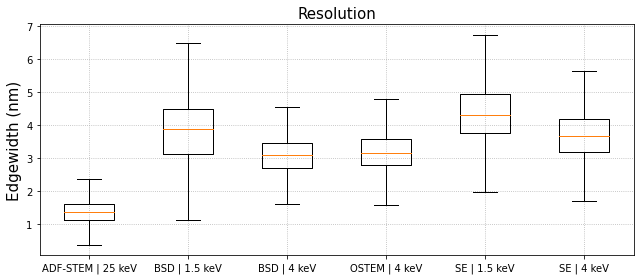

In [100]:
# Data
source4 = df_ew_per_con.copy()
fs = 15

# Make figure
fig, ax = plt.subplots(figsize=(9, 4))
ews = []
labels = []
legend = ['ADF-STEM','BSD','BSD','OSTEM','SE','SE']

# Plot results
for j, grp in enumerate(source4.groupby(by=['DetectionMode', 'LE', 'Dwell'])):
    
    # Aggregate particles per subset of images
    ew_subset = []
    
    # Select subset of images with same detection settings
    for i, row in grp[1].iterrows():
        ew_subset = ew_subset + row['EdgeWidths']
    ews.append(ew_subset)
    labels.append(f"{legend[j]} | {row['LE']} keV")

# Plot boxplot
ax.boxplot(ews, labels=labels, showfliers=False)   

# Axes aesthetics
ax.grid(which='both', ls=':') 
ax.set_title('Resolution', fontsize=fs)
ax.set_ylabel('Edgewidth (nm)', fontsize=fs)
#ax.set_ylim(0, 50)
plt.tight_layout()    
plt.savefig('35%-65%-edgewith', dpi=150)